In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [33]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"] ="LangchainProject"

In [8]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama3-8b-8192")

In [11]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [17]:
### GRAPH WITH TOOL CALL
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """ ADD TWO NUMBERS """
    return a+b
tools = [add]
tool_node=ToolNode([add])
llm_with_tools = llm.bind_functions([add])



In [19]:
from langgraph.prebuilt import tools_condition
#Node Definitoin
def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

graph_builder = StateGraph(State)
graph_builder.add_node("LLMTOOLS",call_llm_model)
graph_builder.add_node("tools",ToolNode(tools))
graph_builder.add_edge(START,"LLMTOOLS")

graph_builder.add_conditional_edges(
    "LLMTOOLS",
    tools_condition
)
graph_builder.add_edge("tools",END)

## Compile The Graph
graph=graph_builder.compile()

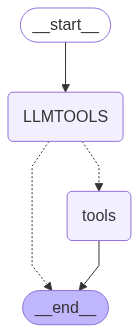

In [22]:
## Compile The Graph

###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
response=graph.invoke({"messages":"What is the recent AI NEWS"})

In [27]:
response=graph.invoke({"messages":"What is 2+2"})

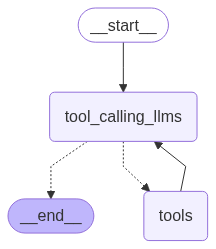

In [29]:
from langgraph.prebuilt import tools_condition
#Node Definitoin
def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llms",call_llm_model)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llms")

builder.add_conditional_edges(
    "tool_calling_llms",
    tools_condition
)
builder.add_edge("tools","tool_calling_llms")
graph=builder.compile()
###---> Visualizing The Graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [32]:
response=graph.invoke({"messages":"What is the 5+5"})